## Dataset description

The dataset that we want to analyze is "Impact of Covid-19 pandemic on the global economy" taken from kaggle (https://www.kaggle.com/datasets/shashwatwork/impact-of-covid19-pandemic-on-the-global-economy). It contains data from 170 countries. We want to use it to choose best linear regression model in order to find how it affected GDP.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV, ElasticNetCV 
from sklearn.pipeline import Pipeline

# Mute the sklearn warning about regularization
import warnings
warnings.filterwarnings('ignore', module='sklearn')

data = pd.read_csv('raw_data[1].csv', sep=',')
data = data.rename(columns={'human_development_index':'hdi'})
data.head()

,iso_code,location,date,total_cases,total_deaths,stringency_index,population,gdp_per_capita,hdi,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,AFG,Afghanistan,2019-12-31,0.0,0.0,0.0,38928341,1803.987,0.498,#NUM!,#NUM!,#NUM!,17.477233,7.497754494
1,AFG,Afghanistan,2020-01-01,0.0,0.0,0.0,38928341,1803.987,0.498,#NUM!,#NUM!,#NUM!,17.477233,7.497754494
2,AFG,Afghanistan,2020-01-02,0.0,0.0,0.0,38928341,1803.987,0.498,#NUM!,#NUM!,#NUM!,17.477233,7.497754494
3,AFG,Afghanistan,2020-01-03,0.0,0.0,0.0,38928341,1803.987,0.498,#NUM!,#NUM!,#NUM!,17.477233,7.497754494
4,AFG,Afghanistan,2020-01-04,0.0,0.0,0.0,38928341,1803.987,0.498,#NUM!,#NUM!,#NUM!,17.477233,7.497754494


## Exploratory data analysis

Here we want to perform exploratory analysis in order to clear all the unnecesary values adn prepare the data for further analysis.

In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50418 entries, 0 to 50417
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   iso_code          50418 non-null  object 
 1   location          50418 non-null  object 
 2   date              50418 non-null  object 
 3   total_cases       47324 non-null  float64
 4   total_deaths      39228 non-null  float64
 5   stringency_index  43292 non-null  float64
 6   population        50418 non-null  int64  
 7   gdp_per_capita    44706 non-null  float64
 8   hdi               44216 non-null  float64
 9   Unnamed: 9        50418 non-null  object 
 10  Unnamed: 10       50418 non-null  object 
 11  Unnamed: 11       50418 non-null  object 
 12  Unnamed: 12       50418 non-null  float64
 13  Unnamed: 13       50418 non-null  object 
dtypes: float64(6), int64(1), object(7)
memory usage: 5.4+ MB


In [3]:
# dropping the unnamed values and the iso_code as we don't need them
data = data.drop(['iso_code', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13'], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50418 entries, 0 to 50417
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   location          50418 non-null  object 
 1   date              50418 non-null  object 
 2   total_cases       47324 non-null  float64
 3   total_deaths      39228 non-null  float64
 4   stringency_index  43292 non-null  float64
 5   population        50418 non-null  int64  
 6   gdp_per_capita    44706 non-null  float64
 7   hdi               44216 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 3.1+ MB


In [4]:
data = data.dropna(axis = 0)
data.isnull().sum()

location            0
date                0
total_cases         0
total_deaths        0
stringency_index    0
population          0
gdp_per_capita      0
hdi                 0
dtype: int64

In [5]:
data.head(10)

,location,date,total_cases,total_deaths,stringency_index,population,gdp_per_capita,hdi
0,Afghanistan,2019-12-31,0.0,0.0,0.0,38928341,1803.987,0.498
1,Afghanistan,2020-01-01,0.0,0.0,0.0,38928341,1803.987,0.498
2,Afghanistan,2020-01-02,0.0,0.0,0.0,38928341,1803.987,0.498
3,Afghanistan,2020-01-03,0.0,0.0,0.0,38928341,1803.987,0.498
4,Afghanistan,2020-01-04,0.0,0.0,0.0,38928341,1803.987,0.498
5,Afghanistan,2020-01-05,0.0,0.0,0.0,38928341,1803.987,0.498
6,Afghanistan,2020-01-06,0.0,0.0,0.0,38928341,1803.987,0.498
7,Afghanistan,2020-01-07,0.0,0.0,0.0,38928341,1803.987,0.498
8,Afghanistan,2020-01-08,0.0,0.0,0.0,38928341,1803.987,0.498
9,Afghanistan,2020-01-09,0.0,0.0,0.0,38928341,1803.987,0.498


<AxesSubplot:>

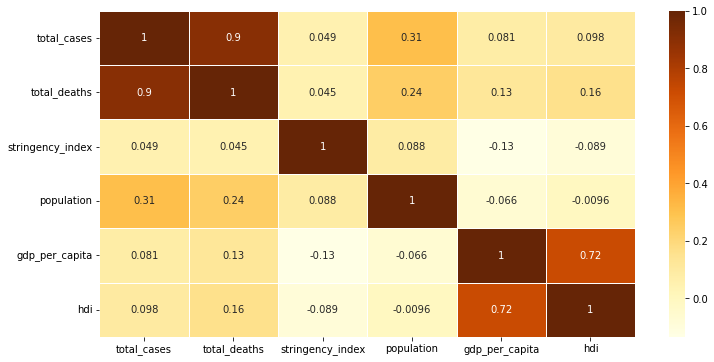

In [6]:
# creating the correlation matrix
corr = data.corr(method='pearson')
fig = plt.subplots(figsize = (12, 6))
sns.heatmap(corr, 
            xticklabels=corr.columns,
            yticklabels=corr.columns,
            cmap='YlOrBr',
            annot=True,
            linewidth=0.5)

We can see that the highest correlation is between gpd_per_capita and hdi, total_deaths and total_cases.

Text(0, 0.5, 'Total nu,mber of deaths')

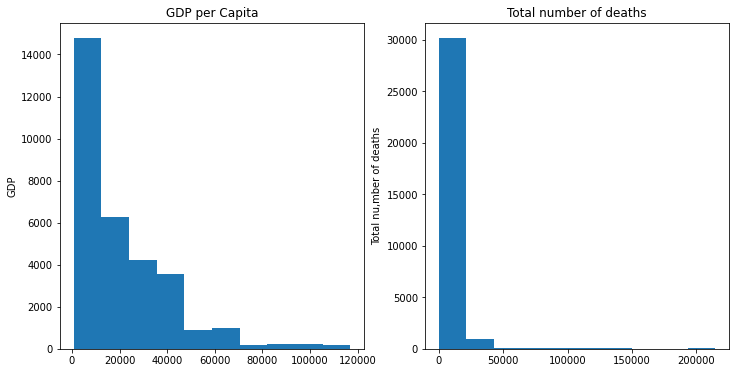

In [7]:
# plotting the data
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.hist(data['gdp_per_capita'])
ax2.hist(data['total_deaths'])
ax1.set_title('GDP per Capita')
ax2.set_title('Total number of deaths')
ax1.set_ylabel('GDP')
ax2.set_ylabel('Total number of deaths')

Text(0, 0.5, 'Total nu,mber of deaths')

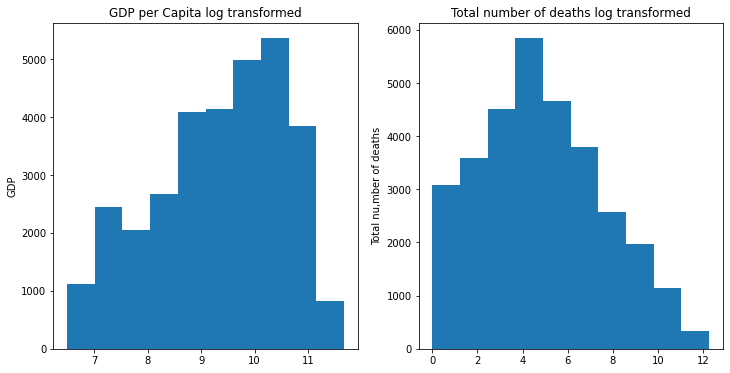

In [8]:
# making the data more normally distributed
gdp_transformed = data['gdp_per_capita'].apply(lambda x: np.log(x+1))
total_deaths_transformed = data['total_deaths'].apply(lambda x: np.log(x+1))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
ax1.hist(gdp_transformed)
ax2.hist(total_deaths_transformed)
ax1.set_title('GDP per Capita log transformed')
ax2.set_title('Total number of deaths log transformed')
ax1.set_ylabel('GDP')
ax2.set_ylabel('Total nu,mber of deaths')

In [9]:
data['gdp_per_capita'] = gdp_transformed
data['total_deaths'] = total_deaths_transformed
data.head()

,location,date,total_cases,total_deaths,stringency_index,population,gdp_per_capita,hdi
0,Afghanistan,2019-12-31,0.0,0.0,0.0,38928341,7.498309,0.498
1,Afghanistan,2020-01-01,0.0,0.0,0.0,38928341,7.498309,0.498
2,Afghanistan,2020-01-02,0.0,0.0,0.0,38928341,7.498309,0.498
3,Afghanistan,2020-01-03,0.0,0.0,0.0,38928341,7.498309,0.498
4,Afghanistan,2020-01-04,0.0,0.0,0.0,38928341,7.498309,0.498


In [10]:
scaler = MinMaxScaler()
numerical = ['total_deaths', 'gdp_per_capita']
features_log_scaled = pd.DataFrame(data = data)
features_log_scaled[numerical] = scaler.fit_transform(data[numerical])
features_log_scaled

,location,date,total_cases,total_deaths,stringency_index,population,gdp_per_capita,hdi
0,Afghanistan,2019-12-31,0.0,0.000000,0.00,38928341,0.193801,0.498
1,Afghanistan,2020-01-01,0.0,0.000000,0.00,38928341,0.193801,0.498
2,Afghanistan,2020-01-02,0.0,0.000000,0.00,38928341,0.193801,0.498
3,Afghanistan,2020-01-03,0.0,0.000000,0.00,38928341,0.193801,0.498
4,Afghanistan,2020-01-04,0.0,0.000000,0.00,38928341,0.193801,0.498
...,...,...,...,...,...,...,...,...
50413,Zimbabwe,2020-10-15,8055.0,0.443642,76.85,14862927,0.203796,0.535
50414,Zimbabwe,2020-10-16,8075.0,0.443642,76.85,14862927,0.203796,0.535
50415,Zimbabwe,2020-10-17,8099.0,0.443642,76.85,14862927,0.203796,0.535
50416,Zimbabwe,2020-10-18,8110.0,0.443642,76.85,14862927,0.203796,0.535


In [11]:
from sklearn.model_selection import train_test_split

x_data = features_log_scaled[['total_cases','total_deaths','stringency_index','population','hdi']]
y_data = features_log_scaled['gdp_per_capita']

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

print('Training set size:{}'.format(x_train.shape[0]))
print('Testing set size: {}'.format(x_test.shape[0]))

Training set size:22062
Testing set size: 9456


## Models

Here we want to find the best model out of three: linear regression, lasso regression, ridge regression.

In [13]:
#linear regression
lr = LinearRegression()

lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
linear_score = r2_score(y_test.values, y_pred)

Text(0, 0.5, '$R^2$')

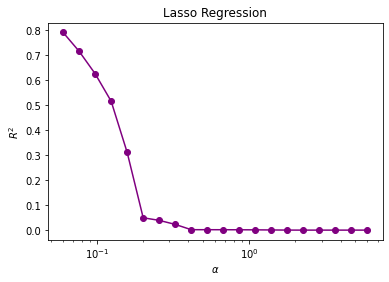

In [14]:
# lasso regression and K-fold cross validation
s = StandardScaler()
pf = PolynomialFeatures(degree=3)
kf = KFold(shuffle=True, random_state=72018, n_splits=3)
scores = []
alphas = np.geomspace(0.06, 6.0, 20)
predictions_lsr = []
for alpha in alphas:
    las = Lasso(alpha=alpha, max_iter=100000)
    
    estimator = Pipeline([
        ("scaler", s),
        ("make_higher_degree", pf),
        ("lasso_regression", las)])

    predictions_lsr = cross_val_predict(estimator, x_train, y_train, cv = kf)
    
    score = r2_score(y_train, predictions_lsr)
    
    scores.append(score)
plt.semilogx(alphas, scores, '-o', color='purple')
plt.title('Lasso Regression')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$')

In [15]:
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=3)),
                    ("lasso_regression", Lasso(alpha=0.03))])

best_estimator.fit(x_train, y_train)
lasso_score = best_estimator.score(x_train, y_train)
lasso_score

0.8802766653138374

Text(0, 0.5, '$R^2$')

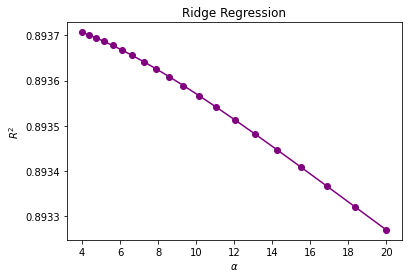

In [16]:
# ridge regression and K-fold cross validation
pf = PolynomialFeatures(degree=2)
alphas = np.geomspace(4, 20, 20)
scores=[]
predictions_rr = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha, max_iter=100000)

    estimator = Pipeline([
        ("scaler", s),
        ("polynomial_features", pf),
        ("ridge_regression", ridge)])

    predictions_rr = cross_val_predict(estimator, x_train, y_train, cv = kf)
    score = r2_score(y_train, predictions_rr)
    scores.append(score)

plt.plot(alphas, scores, '-o', color='purple')
plt.title('Ridge Regression')
plt.xlabel('$\\alpha$')
plt.ylabel('$R^2$')


In [17]:
best_estimator = Pipeline([
                    ("scaler", s),
                    ("make_higher_degree", PolynomialFeatures(degree=2)),
                    ("ridge_regression", Ridge(alpha=0.03))])
best_estimator.fit(x_train,y_train)
ridge_score = best_estimator.score(x_train, y_train)
ridge_score

0.8939618259156772

In [18]:
pd.DataFrame([[linear_score, lasso_score, ridge_score]],columns=['linear', 'lasso', 'ridge'], index=['score'])

,linear,lasso,ridge
score,0.800274,0.880277,0.893962


Ridge regression has the best r2_score.

In [27]:
def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

# Fit a basic linear regression model
linearRegression = LinearRegression().fit(x_train, y_train)
linearRegression_rmse = rmse(y_test, linearRegression.predict(x_test))

# Fit a regular (non-cross validated) Ridge model
alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]
ridgeCV = RidgeCV(alphas=alphas, cv=4).fit(x_train, y_train)
ridgeCV_rmse = rmse(y_test, ridgeCV.predict(x_test))

# Fit a Lasso model using cross validation and determine the optimum value for 𝛼
alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])
lassoCV = LassoCV(alphas=alphas2,
                  max_iter=100000,
                  cv=3).fit(x_train, y_train)
lassoCV_rmse = rmse(y_test, lassoCV.predict(x_test))


rmse_vals = [linearRegression_rmse, ridgeCV_rmse, lassoCV_rmse]

labels = ['Linear', 'Lasso', 'Ridge']

rmse_df = pd.DataFrame([[linearRegression_rmse, ridgeCV_rmse, lassoCV_rmse]],columns=['Linear', 'Lasso', 'Ridge'], index=['rmse'])
rmse_df


,Linear,Lasso,Ridge
rmse,0.105324,0.105324,0.105324


## Conclusion
We analyzed the data and determined that the best model would be the ridge regression as it had the best r2_score and for the rmse, all model did the same.
For the further analysis we could try to make a model thet predicts the GDP changes for each of the individual countries.
